In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import itertools

from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
from tqdm import tqdm

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA, NMF, IncrementalPCA, FastICA, LatentDirichletAllocation, TruncatedSVD
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding, TSNE

plt.style.use("ggplot")

In [2]:
#
# Load the data from pickled class created in "dataset_parser"
#
data = pickle.load(open("dataset_alphabay.p","rb"))

pprint(data[0].keys())

[u'category', u'description', u'soldby', u'country', u'price', u'title']


In [3]:
#
# Construct the data - X and Y (input/output)
#
description = [x.get("description") for x in data]
category = [x.get("category").split("/")[0] for x in data]
category_subs = [x.get("category") for x in data]
weapon = [u'Weapons' in x for x in category]

print "weapons:", weapon.count(1), "("+str(weapon.count(0))+")"
print float(weapon.count(1))/float(weapon.count(0))*100, "% weapons"

weapons: 76 (5507)
1.3800617396 % weapons


In [4]:
# 
# Removing non-english
#
def language_eng():
    from langdetect import detect,detect_langs
    global category
    global description

    for dt in tqdm(data):
        if detect(dt.get("description")) != "en":
            continue
        description.append(dt.get("description"))
        category.append(dt.get("category").split("/")[0])

In [5]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# vect = CountVectorizer(tokenizer=LemmaTokenizer())  

In [6]:
#
# count vectoriser - 
# Ret: matrix containing occurance of word in document 
#
# print(X_train_counts) 
#   (document, word_id, occurances)
#   (0, 5976)	2
#   (0, 15089)	1
#   (0, 7283)	1
#
def count_word_matrix():
    global X_train_counts
    count_vect = CountVectorizer(tokenizer=LemmaTokenizer()) #stop_words = 'english', min_df=0.0008
    X_train_counts = count_vect.fit_transform(description)
    print(X_train_counts.shape)
    
# count_word_matrix()

In [7]:
#
# count vectoriser - 
# Ret: matrix containing tf-idf representation
#
# print(X_train_tf) 
#   (document, word_id, freq.)
#   (0, 22411)	0.0866296163648
#   (0, 5976)	0.0866296163648
#   (0, 21638)	0.0433148081824
#
def tfidf_matrix():
    global X_train_tfidf
    tfidf_transformer = TfidfTransformer(use_idf=True)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    print(X_train_tfidf.shape)
    
# tfidf_matrix()

In [15]:
#
# TFIDF w/o using countvectorizer (Equivalent to CountVectorizer + TfidfTransformer)
#
def tfidf():
    global X_train_tfidf
    tfidf_transformer = TfidfVectorizer(use_idf=True,
#                                         tokenizer=LemmaTokenizer(),
                                        stop_words='english')
    
    X_train_tfidf = tfidf_transformer.fit_transform(description)
    print(X_train_tfidf.shape)
    
tfidf()

(5583, 24394)


In [9]:
#
# Problem and target 
#
problem = category
input_data = X_train_tfidf

y_classes = list(set(problem))
y_ = [y_classes.index(x) for x in problem]

In [34]:
# train data and target split
X_train, X_test, y_train, y_test = train_test_split(input_data, problem)

clf =  sklearn.naive_bayes.BernoulliNB().fit(X_train, y_train)
print("NB - bernouli:",clf.score(X_test, y_test))

clf =  sklearn.svm.SVC().fit(X_train, y_train)
print("SVM - vanilla:",clf.score(X_test, y_test))

clf =  sklearn.svm.LinearSVC().fit(X_train, y_train)
print("SVM - linear:",clf.score(X_test, y_test))

clf = SGDClassifier().fit(X_train, y_train)
print("SGD - vanilla",clf.score(X_test, y_test))

clf = sklearn.linear_model.RidgeClassifier().fit(X_train, y_train)
print("SGD - ridgeC",clf.score(X_test, y_test))

clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
print("KNN - vanilla:",clf.score(X_test, y_test))

('NB - bernouli:', 0.51074498567335247)
('SVM - vanilla:', 0.38108882521489973)
('SVM - linear:', 0.74283667621776506)
('SGD - vanilla', 0.75501432664756452)
('SGD - ridgeC', 0.72492836676217765)
('KNN - vanilla:', 0.38610315186246419)


In [28]:
clf = sklearn.svm.LinearSVC(multi_class='crammer_singer').fit(X_train, y_train) #multi = crammer_singer,penalty='l1', dual=0, 
print(clf) 
print(clf.score(X_test,y_test))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)
0.805157593123


('Accuracy:', 0.82507462686567168)
Confusion matrix, without normalization
[[  1   0   1   0   5   4   0   0   0   0   0   0]
 [  0  29   2   2   4   2   0   0   0   1   0   0]
 [  0   0  79  12  30  16   0   0   0   9   1   1]
 [  0   0   2 660   2   1   0   0   0   0   0   0]
 [  2   2  10  17 364  30   0   4   0  13   4   0]
 [  0   0   4   8  32 151   0   0   0   3   0   1]
 [  0   0   0   0   0   1   7   0   0   0   0   0]
 [  0   0   1   7   6   3   0  11   1   3   0   0]
 [  0   0   1   0   2   0   0   0   0   0   1   0]
 [  0   3   3   1  18   1   0   1   0  58   0   0]
 [  0   0   1   2   7   1   0   0   0   0   6   0]
 [  0   0   0   3   1   0   0   0   0   0   0  16]]
Normalized confusion matrix
[[ 0.09  0.    0.09  0.    0.45  0.36  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.72  0.05  0.05  0.1   0.05  0.    0.    0.    0.03  0.    0.  ]
 [ 0.    0.    0.53  0.08  0.2   0.11  0.    0.    0.    0.06  0.01  0.01]
 [ 0.    0.    0.    0.99  0.    0.    0.    0.    0.    0.

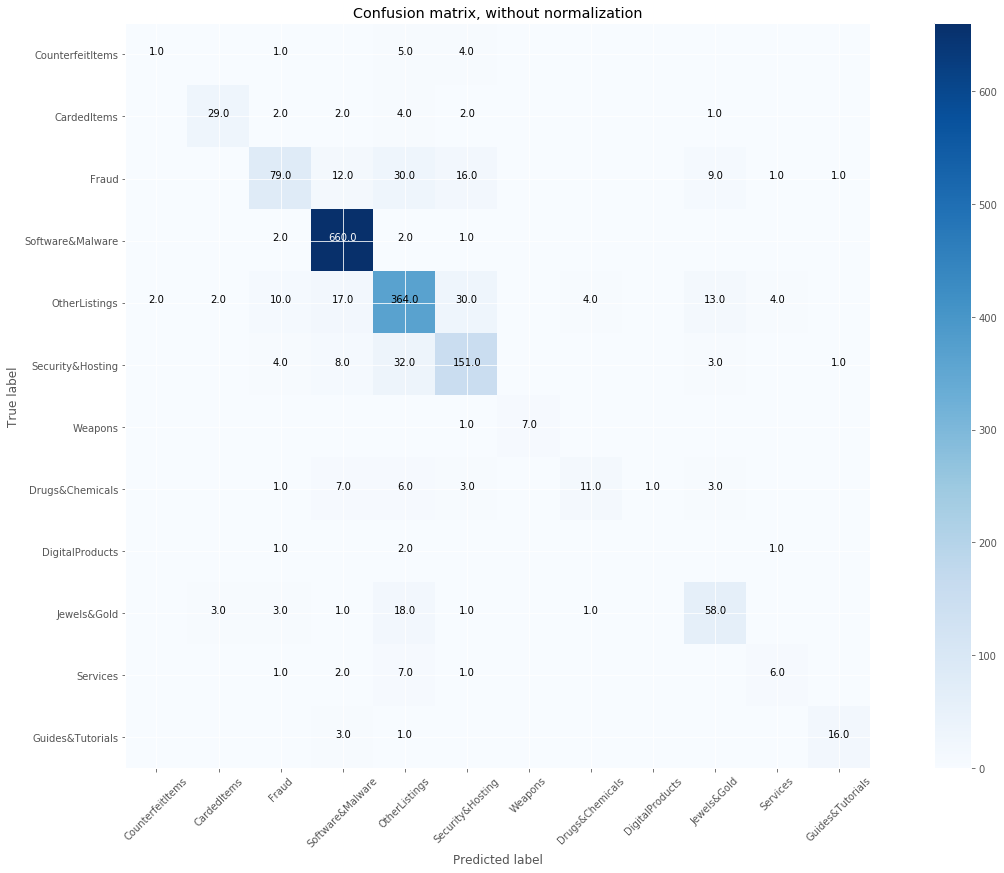

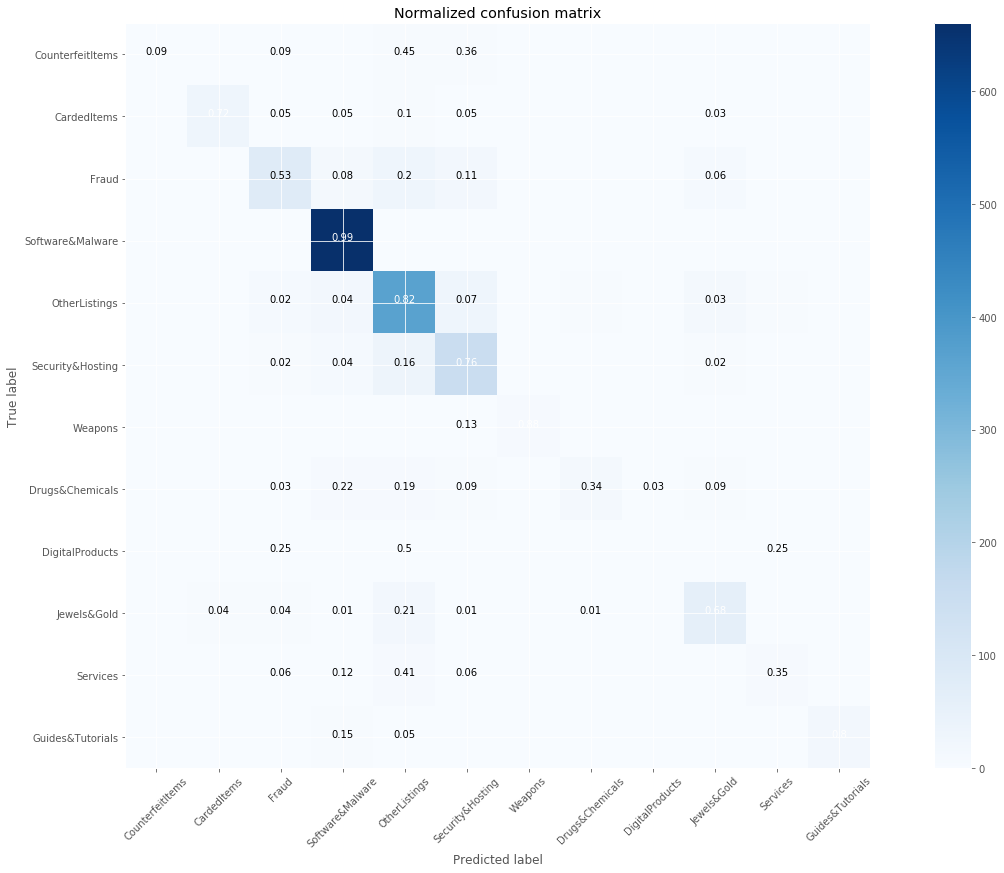

In [34]:
%matplotlib inline

X_train, X_test, y_train, y_test = train_test_split(input_data, problem, test_size=0.3)
class_names = list(set(problem))

clf = sklearn.svm.LinearSVC(penalty='l1', dual=0, multi_class='crammer_singer').fit(X_train, y_train)
print("Accuracy:",clf.score(X_test, y_test))
classifier = clf

y_pred = classifier.predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cmap=plt.cm.Blues
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0., vmax=cm.max())
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    thresh = cm.max() * 0.66
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] < 0.01:
            continue
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(18,12)

# Plot non-normalized confusion matrix
# plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(18, 12)

# Plot normalized confusion matrix
# plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


plt.show()

In [13]:
# X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, category)
# import sklearn.cluster

# clf = sklearn.cluster.AffinityPropagation().fit(X_train, y_train)

# print(clf.fit_predict(X_test, y_test))

In [14]:
# # af = AffinityPropagation(preference=-50).fit(X)
# from sklearn import metrics

# af = clf
# cluster_centers_indices = af.cluster_centers_indices_
# labels = af.labels_
# labels_true = y_test
# X = X_test
# n_clusters_ = len(cluster_centers_indices)

# print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X.todense(), labels, metric='sqeuclidean'))

In [173]:
# input_data = [X]
X_train, X_test, y_train, y_test = train_test_split(X, problem, test_size=0.5)

# outl = OneClassSVM()
# outl = IsolationForest()
# outl = GaussianMixture(n_components=10)
outl = KernelDensity()

outl.fit(X_train, y_train)
y_out = outl.score_samples(X)

In [155]:
inliers = float(outl.predict(X_test).tolist().count(1))/len(y_test)*100
y_out = outl.predict(X_test)

print("Inliers: {}%".format(round(inliers,1)))

Inliers: 3.0%


In [ ]:
clf = sklearn.neighbors.KNeighborsClassifier().fit(X_train, y_train)
print("Accuracy:",clf.score(X_test,y_test))

from pandas import DataFrame
col = []
for i, da in enumerate(y_test):
    if b'Wea' in da:
        pred_y = clf.predict(X_test[i])[0]
        ol = 1!=outl.predict(X_test[i])[0]
        col.append([da,pred_y,ol])

df = DataFrame(col,columns=["Y_true","Y_predicted","outlier"])
# print(df.loc(df["outlier"]==True))

In [139]:
print("Hits:",df.shape[0])
print("Wrong pred:",df.loc[df["Y_true"]!=df["Y_predicted"]].shape[0])
print("Correct pred:",df.loc[df["Y_true"]==df["Y_predicted"]].shape[0])
print("Outliers:",df.loc[df["outlier"]==1].shape[0])
print("Outliers & wrong prediction:",df.loc[df["outlier"]==1][df["Y_true"]!=df["Y_predicted"]].shape[0])
df.loc[df["Y_true"]!=df["Y_predicted"]]

('Hits:', 20)
('Wrong pred:', 18)
('Correct pred:', 2)
('Outliers:', 20)
('Outliers & wrong prediction:', 18)


,Y_true,Y_predicted,outlier
0,Weapons,Drugs&Chemicals,True
1,Weapons,Fraud,True
2,Weapons,DigitalProducts,True
3,Weapons,Drugs&Chemicals,True
4,Weapons,Fraud,True
5,Weapons,Drugs&Chemicals,True
6,Weapons,Drugs&Chemicals,True
9,Weapons,Guides&Tutorials,True
10,Weapons,Drugs&Chemicals,True
11,Weapons,Drugs&Chemicals,True


In [98]:
# ii=0
# for i,x in enumerate(y_test):
# #     if b'Weapon' in x:
# #         print(i,x,"Outlier:",clf.predict(X_test[i])==True)
# #         ii+=1
#     if clf.predict(X_test[i]):
#         ii+=1
        
# print(ii)
# print(len(y_test))
# print(ii/len(y_test),"inliers")

In [11]:
#
# reduce dimension
# Input: out dimension size - eg. 3
# Out:   X
#

def red_dimen(to):
    pca = TruncatedSVD(n_components=100)
    pca.fit(input_data)
    X = pca.transform(input_data)

#     pca = Isomap(n_components=to)
    pca = PCA(n_components=to)
    pca.fit(X)
    X = pca.transform(X)
    return X

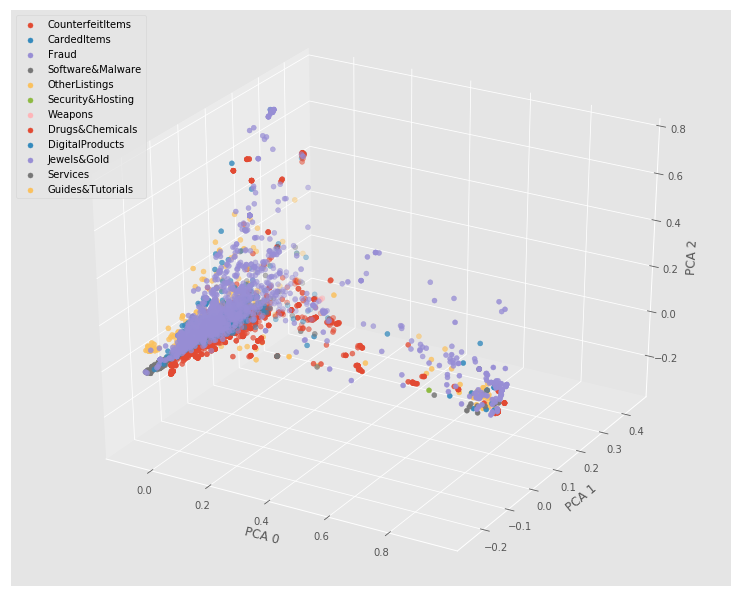

In [197]:
#
# Plot X (3D)  
# Input: X (global)
#
X = red_dimen(3)

def plot_data():

    %matplotlib inline
    #inline, gtk, osx, tk, empty uses defaultgtk

    fig = plt.figure(1, figsize=(10, 8))
    ax = Axes3D(fig)

    y = problem

    for name, label in zip(list(set(problem)), list(set(y))):
#         if "outlier" in str(name):# or u'Jewels&Gold' in name or u'Services' in name or u'Software&Malware' in name:
#             continue
        ax.scatter(X[[label==t for t in y], 0], 
                  X[[label==t for t in y], 1],
                  X[[label==t for t in y], 2], label=name, s=25)
    #     ax.text3D(X[[label==t for t in y], 0].mean(),
    #               X[[label==t for t in y], 1].mean(),
    #               X[[label==t for t in y], 2].mean(), name)          

    plt.legend(loc='upper left')
    ax.set_xlabel('PCA 0')
    ax.set_ylabel('PCA 1')
    ax.set_zlabel('PCA 2')
    plt.show()
    
plot_data()

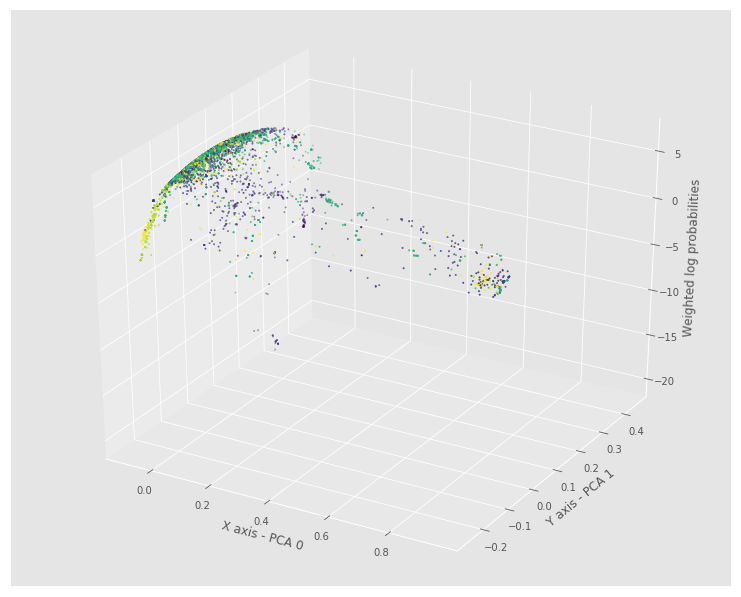

In [196]:
#
# Plot X (3D)  
# Input: X (global)
#

X = red_dimen(3)

outl = GaussianMixture(n_components=2)
outl.fit(X)
outliers = outl.score_samples(X)

def plot_data():
    %matplotlib inline
    #inline, gtk, osx, tk, empty uses defaultgtk
    fig = plt.figure(1, figsize=(10, 8))
    ax = Axes3D(fig)
    ax.scatter(X[:, 0], X[:, 1], outliers, s=2, c=y_)
    ax.set_xlabel('X axis - PCA 0')
    ax.set_ylabel('Y axis - PCA 1')
    ax.set_zlabel('Weighted log probabilities')
    plt.show()
    
plot_data()

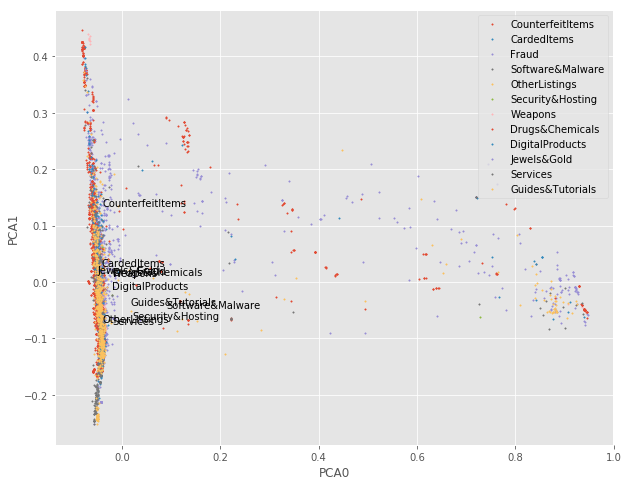

In [129]:
#
# Plot X (2D)  
# Input: X2d (global)
#

X2d = red_dimen(2)
    
def plot_data():
    %matplotlib inline
    fig = plt.figure(figsize=(10,8))
    y = problem
    
    for name in list(set(y)):
        plt.scatter(X2d[[name==t for t in y], 0],
                    X2d[[name==t for t in y], 1],
                    label=name, s=2)
        
        plt.text(X2d[[name==t for t in y], 0].mean(),
                 X2d[[name==t for t in y], 1].mean(),
                 name)

    plt.xlabel("PCA0")
    plt.ylabel("PCA1")
    plt.legend(loc='upper right')
    plt.show()
    
plot_data()

In [ ]:
# pca = PCA(n_components=100)
pca = TruncatedSVD(n_components=4000)
tmp = X_train_tfidf.toarray()
pca.fit(tmp)
pca_X = pca.transform(tmp)


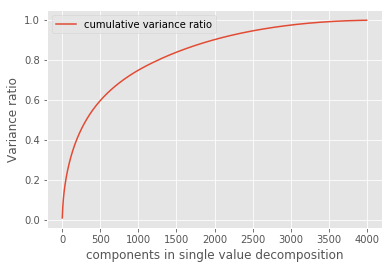

In [25]:
# ----
# print pca.explained_variance_
# sort_w = pca.components_[0].sort()

plt.ylabel("Variance ratio")
plt.xlabel("components in single value decomposition")
cumulative = np.cumsum(pca.explained_variance_ratio_)

# plt.plot(pca.explained_variance_, label="variance")
# plt.plot(pca.explained_variance_ratio_, label="variance ratio")
plt.plot(cumulative, label="cumulative variance ratio")
plt.legend()

plt.show()

In [21]:
print(pca.n_components,cumulative[-1])

(4000, 0.99885399390971663)


In [18]:
X_train_tfidf.shape

(5583, 24394)